<a href="https://colab.research.google.com/github/oyjuffer/DL-Final/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL as pil
import tensorflow as tf
import pandas as pd

from data_augmentation import ImageGenerator

from tensorflow import keras, math
from keras.models import Sequential

from keras.layers import Activation, Convolution2D, Dropout, Conv2D, Rescaling, Dense
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os, shutil

random_seed = 40
keras.utils.set_random_seed(random_seed)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# # dataset directory.
# data_dir= "/content/drive/MyDrive/FER-2013/"

# Data loading + training/validation dataset split

In [3]:
data_dir= "emotion-detection-fer/"

### Data augmentation on the training dataset

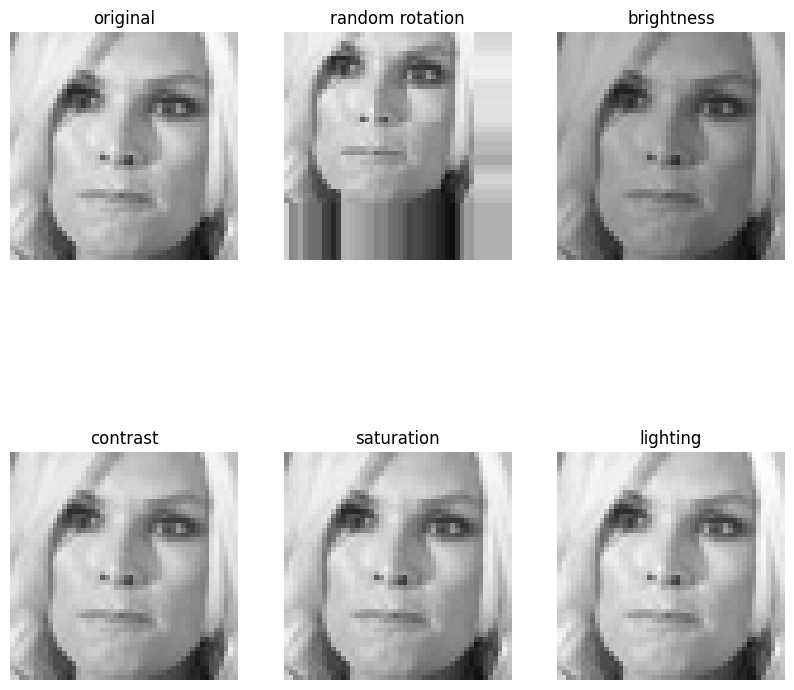

In [3]:
img_generator = ImageGenerator()

img = keras.utils.img_to_array(keras.utils.load_img(data_dir+"train_ext_copy/angry/Training_33331.jpg"))

new_imgs = [img_generator.do_random_rotation(img), img_generator.brightness(img), img_generator.contrast(img), 
            img_generator.saturation(img), img_generator.lighting(img)]

labels = ["original", "random rotation", "brightness", "contrast", "saturation", "lighting"]
plt.figure(figsize=(10, 10))
ii = 0
for image in [img] + new_imgs:
  ax = plt.subplot(2, 3, ii + 1)
  plt.imshow(image.astype("uint8"))
  plt.title(labels[ii])
  plt.axis("off")
  
  ii += 1

For each image in the train_ext_copy folder (80% of the original training folder), 6 new images are created per original image

In [46]:
img_generator = ImageGenerator()

# clears folder
for folder in os.listdir(data_dir+"train_ext/"):
  shutil.rmtree(data_dir+"train_ext/"+folder)

labels = ["original", "random rotation", "brightness", "contrast", "lighting"]
# generates new images
for folder in os.listdir(data_dir+"train_ext_copy/"):
  os.mkdir(data_dir+"train_ext/"+folder)
  
  for img_name in os.listdir(data_dir+"train_ext_copy/"+folder):
    img_path = data_dir+"train_ext_copy/"+folder+"/"+img_name
    img = keras.utils.img_to_array(keras.utils.load_img(img_path))
    new_imgs = [img_generator.do_random_rotation(img), img_generator.brightness(img), img_generator.contrast(img),
                img_generator.lighting(img)]
    
    ii = 0
    for image in [img] + new_imgs:
      img_keras = keras.utils.array_to_img(image)
      new_img_name = "{}_{}.jpg".format(img_name.replace(".jpg", ""), labels[ii])
      img_keras.save(data_dir+"train_ext/"+folder+"/"+new_img_name)
      ii+=1
    

If ext_flag=0, then the 80/20 % of the original train folder are used for training validation, while if ext_flag=1, then it is used an augmented version of the training data

In [4]:
image_size = 48 # 48x48 gray scale images
batch_size = 32 # default batch size

ext_flag=1

if ext_flag:

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "train_ext/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')
  
  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "val_ext/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')
  
else:
  
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + "train/",
    image_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode='grayscale')

  train_ds, val_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8, seed=random_seed)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + "test/",
  image_size=(image_size, image_size),
  batch_size=batch_size,
  color_mode='grayscale')

Found 129069 files belonging to 7 classes.
Found 5741 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


### Analyze datasets

In [48]:
def print_ds_inf(ds, case=""):
    n_classes = 7 # 7 different expressions
    n_per_class = np.zeros(n_classes)
    
    for element in ds.as_numpy_iterator():
        labels = element[1]
        for lab in labels:
            n_per_class[lab] += 1
    n_total = np.sum(n_per_class)
    
    print(case+" -> Total: {}, Per_class: {}".format(n_total, n_per_class))
        
print_ds_inf(train_ds, "Train")
print_ds_inf(val_ds, "Validation")
print_ds_inf(test_ds, "Test")

Train -> Total: 114840.0, Per_class: [15980.  1745. 16390. 28860. 19860. 19320. 12685.]
Validation -> Total: 5741.0, Per_class: [ 799.   87.  819. 1443.  993.  966.  634.]
Test -> Total: 7178.0, Per_class: [ 958.  111. 1024. 1774. 1233. 1247.  831.]


In [5]:
class_names = test_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


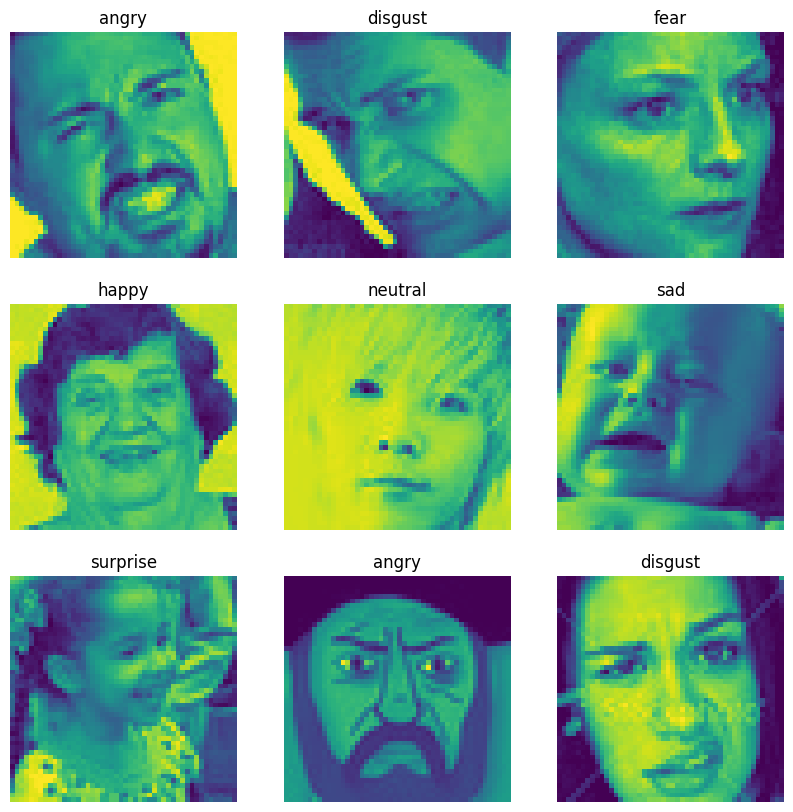

In [27]:
plt.figure(figsize=(10, 10))
class_names_plot = class_names + ['angry', 'disgust']

i = 0
for element in train_ds.as_numpy_iterator():
  images = element[0]
  labels = element[1]

  for image, label in zip(images, labels):
    
    if class_names_plot[i] == class_names[int(label)]:
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image.astype("uint8"))
      plt.title(class_names[label])
      plt.axis("off")
      
      i+=1
      
      if i == 9: break
  if i == 9: break
    
    
plt.savefig('traing_images_example.png')

# CNN arquitectures

### Original CNN arquitecture

In [28]:
num_classes = len(class_names)

model = Sequential(name="Default-preliminary")
model.add(Rescaling(1./255, input_shape=(image_size, image_size, 1))) # images are in the range [0 255]

model.add(Conv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=256, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # labels are provided as integers
  metrics=['accuracy']) # computes the accuracy


Model: "Default-preliminary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        6416      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 48, 48, 16)

### Reduced CNN-arquitecture with separable convolutions

In [49]:
num_classes = len(class_names)

model = Sequential(name="Reduced")
model.add(Rescaling(1./255, input_shape=(image_size, image_size, 1))) # images are in the range [0 255]

model.add(Conv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(SeparableConv2D(filters=32, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.5))

model.add(SeparableConv2D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(SeparableConv2D(filters=128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.25))

model.add(SeparableConv2D(filters=256, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes))

model.summary()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # labels are provided as integers
  metrics=['accuracy']) # computes the accuracy


Model: "Reduced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 48, 48, 16)        416       
                                                                 
 batch_normalization_49 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                                 
 separable_conv2d_30 (Separa  (None, 48, 48, 16)       672       
 bleConv2D)                                                      
                                                                 
 batch_normalization_50 (Bat  (None, 48, 48, 16)       64        
 chNormalization)                                                
                                                           

### Training function + basic visualization/storage

In [50]:
def train_model(model, train=train_ds, validation=val_ds, epochs=10, patience=4, workers=4):
  early_stop = EarlyStopping(monitor="val_loss", patience=patience)
  reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/2), verbose=1, min_lr=0.0001)
  
  
  callbacks = [early_stop]

  history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=epochs,
    workers=workers
  )
  
  return history

In [51]:
history = train_model(model, epochs=30, patience=4)

Epoch 1/30
3589/3589 [==============================] - 458s 127ms/step - loss: 1.6215 - accuracy: 0.3514 - val_loss: 1.3937 - val_accuracy: 0.4597
Epoch 2/30
3589/3589 [==============================] - 397s 111ms/step - loss: 1.4401 - accuracy: 0.4405 - val_loss: 1.3008 - val_accuracy: 0.4990
Epoch 3/30
3589/3589 [==============================] - 368s 103ms/step - loss: 1.3771 - accuracy: 0.4693 - val_loss: 1.2582 - val_accuracy: 0.5156
Epoch 4/30
3589/3589 [==============================] - 403s 112ms/step - loss: 1.3388 - accuracy: 0.4838 - val_loss: 1.2329 - val_accuracy: 0.5300
Epoch 5/30
3589/3589 [==============================] - 424s 118ms/step - loss: 1.3132 - accuracy: 0.4944 - val_loss: 1.2184 - val_accuracy: 0.5372
Epoch 6/30
3589/3589 [==============================] - 387s 108ms/step - loss: 1.2948 - accuracy: 0.5027 - val_loss: 1.2153 - val_accuracy: 0.5377
Epoch 7/30
3589/3589 [==============================] - 354s 99ms/step - loss: 1.2804 - accuracy: 0.5095 - val_l

In [52]:
model.save("cnn_trained_separable_ext_dataset_dropout", overwrite=True)

INFO:tensorflow:Assets written to: cnn_trained_separable_ext_dataset_dropout\assets


INFO:tensorflow:Assets written to: cnn_trained_separable_ext_dataset_dropout\assets


In [6]:
from keras.models import load_model
model_trained = load_model('cnn_trained_ext_dataset_dropout')

225/225 [==============================] - 9s 38ms/step - loss: 1.0664 - accuracy: 0.6154


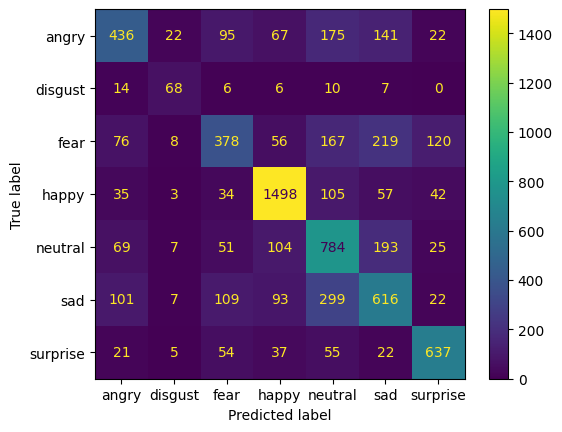

In [7]:
test_loss, test_acc = model_trained.evaluate(test_ds)

labels = []; predictions = []
for element in test_ds.as_numpy_iterator():
    preds = model_trained.predict(element[0], batch_size=batch_size, verbose=0)
    
    for ii in range(len(preds)):
        labels.append(class_names[element[1][ii]])
        predictions.append(class_names[preds[ii].argmax()])
        
cm = confusion_matrix(labels, predictions, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

plt.savefig('cnn_confussion_matrix.png')
plt.show()


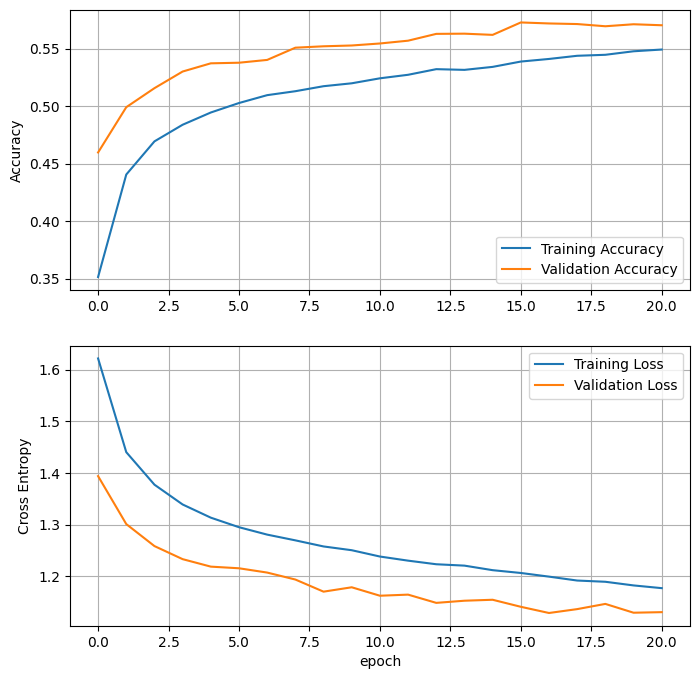

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.grid()
# plt.ylim([min(plt.ylim()),1])
# plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.title('Training and Validation Loss')
plt.grid()
plt.xlabel('epoch')

plt.savefig('ext_dataset_separable_dropout.png')
plt.savefig('ext_dataset_separable_dropout.eps')

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


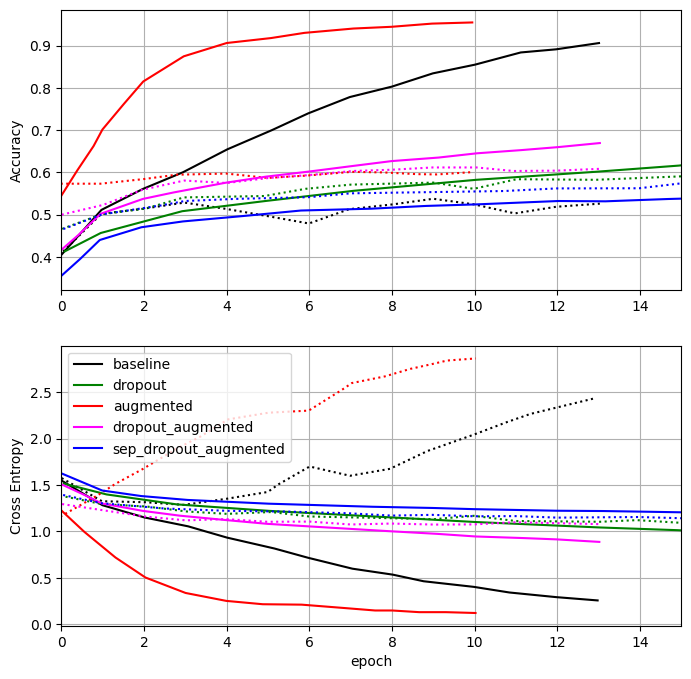

In [26]:
fd_results = 'Results/'

names = []; trainAcc = []; valAcc = []; trainLoss = []; valLoss = []

folders = ['baseline', 'dropout', 'augmented', 'dropout_augmented', 'sep_dropout_augmented']

for folder in folders:
    train_acc = pd.read_csv("{}{}/{}".format(fd_results, folder, "train_acc.csv"))
    val_acc = pd.read_csv("{}{}/{}".format(fd_results, folder, "val_acc.csv"))
    
    train_loss = pd.read_csv("{}{}/{}".format(fd_results, folder, "train_loss.csv"))
    val_loss = pd.read_csv("{}{}/{}".format(fd_results, folder, "val_loss.csv"))
    
    names.append(folder)
    
    trainAcc.append(train_acc)
    valAcc.append(val_acc)
    trainLoss.append(train_loss)
    valLoss.append(val_loss)
    
    

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
colors = ['black', 'green', 'red', 'magenta', 'blue']
for ii in range(5):
    plt.plot(trainAcc[ii]["x"], trainAcc[ii][" y"], '-', color=colors[ii], label=names[ii])
    plt.plot(valAcc[ii]["x"], valAcc[ii][" y"], ':',  color=colors[ii])

# plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,15])
plt.grid()


plt.subplot(2, 1, 2)
for ii in range(5):
    plt.plot(trainLoss[ii]["x"], trainLoss[ii][" y"], '-',  color=colors[ii], label=names[ii])
    plt.plot(valLoss[ii]["x"], valLoss[ii][" y"], ':',  color=colors[ii])

plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.grid()
plt.xlim([0,15])
plt.xlabel('epoch')

plt.savefig('all_together.png')
plt.savefig('all_together.eps')

plt.show()
